# Real World Classification Tradeoffs

In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics, datasets
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
titanic = titanic[['sex', 'age', 'class', 'survived']]

# Rename 'class' col to 'pclass' to avoid namespace issues
titanic.columns = ['sex', 'age', 'pclass', 'survived']

#Drop any row with NA values in any col in dataframe
titanic = titanic.dropna()

is_female = pd.get_dummies(titanic.sex)['female']
pclass_coded = pd.get_dummies(titanic.pclass)[['First','Second']]

titanic_c = pd.concat([is_female,pclass_coded,titanic[['age','survived']]],axis=1)
titanic_c.head()

,female,First,Second,age,survived
0,0,0,0,22.0,0
1,1,1,0,38.0,1
2,1,0,0,26.0,1
3,1,1,0,35.0,1
4,0,0,0,35.0,0


In [4]:
logit = LogisticRegression(C = 100000)
train,test = train_test_split(titanic_c,test_size = 0.2,random_state = 123)
X_train = train.loc[: ,train.columns != 'survived']

In [5]:
X_test = test.loc[:,test.columns !='survived']
y_train = train['survived']
y_test = test['survived']

In [6]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((571, 4), (143, 4), (571,), (143,))

In [7]:
logit.fit(X_train,y_train)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
logit.score(X_train,y_train)

0.8038528896672504

In [9]:
logit.score(X_test,y_test)

0.7552447552447552

In [10]:
logit.coef_

array([[ 2.66232949,  2.59621066,  1.13820871, -0.03594793]])

In [11]:
from sklearn.metrics import roc_curve,auc

In [12]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    plt.figure(figsize=(12,12))
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

sns.set_context("poster")

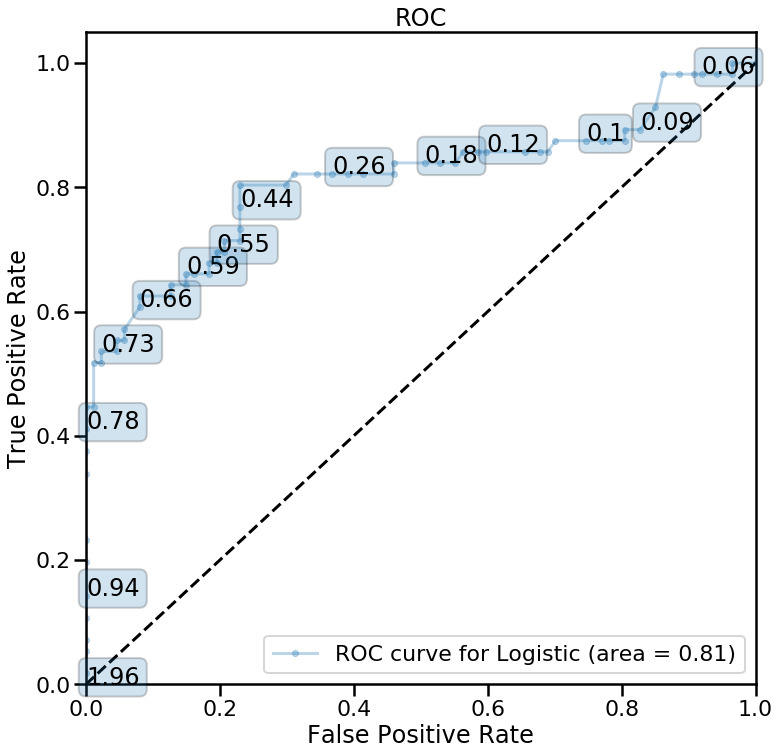

In [13]:
make_roc('Logistic',logit,y_test,X_test)

In [16]:
predict_prob = logit.predict_proba(X_test)[:,1]

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict_prob>0.5))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80        87
           1       0.68      0.70      0.69        56

    accuracy                           0.76       143
   macro avg       0.74      0.74      0.74       143
weighted avg       0.76      0.76      0.76       143



In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predict_prob>0.5)

array([[69, 18],
       [17, 39]], dtype=int64)

In [21]:
pd.crosstab(y_test,predict_prob>0.5,margins=True,dropna=True)

col_0,False,True,All
survived,,,
0,69,18,87
1,17,39,56
All,86,57,143


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict_prob>0.75))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86        87
           1       0.97      0.52      0.67        56

    accuracy                           0.80       143
   macro avg       0.86      0.75      0.77       143
weighted avg       0.84      0.80      0.79       143



In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predict_prob>0.75)

array([[86,  1],
       [27, 29]], dtype=int64)

In [24]:
store_train = pd.read_csv("https://raw.githubusercontent.com/nathanielburbank/CS109/master/s7_data/store_data_train.csv")
store_test = pd.read_csv("https://raw.githubusercontent.com/nathanielburbank/CS109/master/s7_data/store_data_test.csv")
store_train.head()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes,PREGNANT
0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [25]:
store_train.groupby('PREGNANT').count()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes
PREGNANT,,,,,,,,,,,,,,
0,500,500,500,500,500,500,500,500,500,500,500,500,500,500
1,500,500,500,500,500,500,500,500,500,500,500,500,500,500


In [26]:
store_test.groupby('PREGNANT').count()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes
PREGNANT,,,,,,,,,,,,,,
0,940,940,940,940,940,940,940,940,940,940,940,940,940,940
1,60,60,60,60,60,60,60,60,60,60,60,60,60,60


In [29]:
logit = LogisticRegression(C=1000000)
X_train = store_train.iloc[:,:14]
y_train = store_train.PREGNANT

X_test = store_test.iloc[:,:14]
y_test = store_test.PREGNANT

logit.fit(X_train, y_train) 
logit.score(X_test,y_test)

0.887

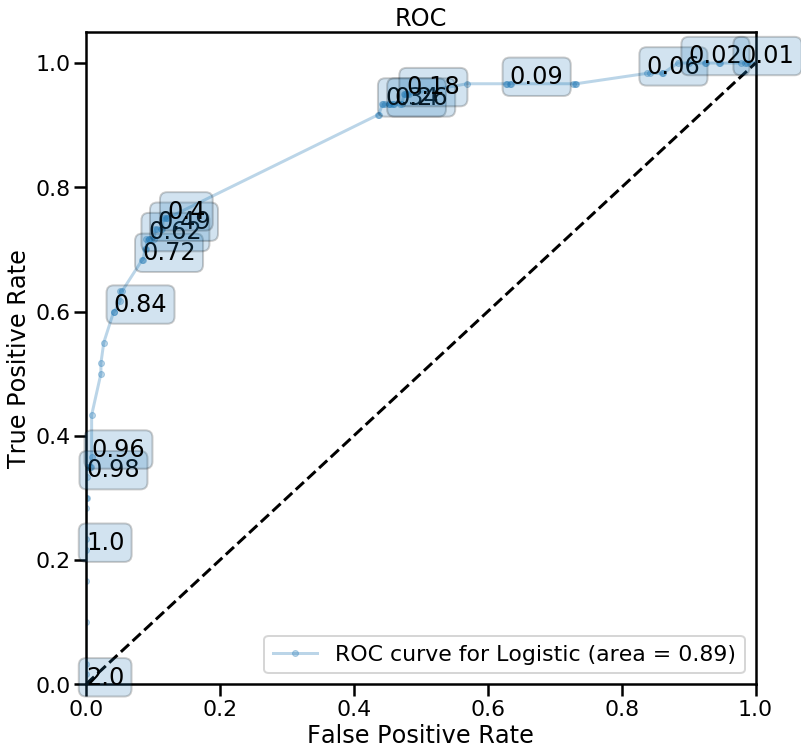

In [30]:
make_roc('Logistic',logit,y_test,X_test)

In [31]:
predicted = logit.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       940
           1       0.31      0.73      0.44        60

    accuracy                           0.89      1000
   macro avg       0.65      0.82      0.69      1000
weighted avg       0.94      0.89      0.91      1000



In [32]:
pd.crosstab(y_test,predicted,margins=True,dropna=False)

col_0,0,1,All
PREGNANT,,,
0,843,97,940
1,16,44,60
All,859,141,1000
